In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
# Define a simple CNN model with sigmoid activation and optional BatchNorm
class DeepSigmoidCNN(nn.Module):
    def __init__(self, use_batchnorm=False):
        super(DeepSigmoidCNN, self).__init__()
        self.use_batchnorm = use_batchnorm
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        
        if self.use_batchnorm:
            self.bn1 = nn.BatchNorm2d(16)
            self.bn2 = nn.BatchNorm2d(32)
            self.bn3 = nn.BatchNorm2d(64)
            self.bn4 = nn.BatchNorm2d(128)
            self.bn5 = nn.BatchNorm2d(256)
            self.bn6 = nn.BatchNorm2d(512)
            self.bn7 = nn.BatchNorm2d(1024)
        self.sigmoid = nn.ReLU()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = None  # Placeholder for dynamically setting fc layer
    
    def forward(self, x):
        x = self.conv1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = self.sigmoid(x)
        
        x = self.conv2(x)
        if self.use_batchnorm:
            x = self.bn2(x)
        x = self.sigmoid(x)
        
        x = self.conv3(x)
        if self.use_batchnorm:
            x = self.bn3(x)
        x = self.sigmoid(x)
        
        x = self.conv4(x)
        if self.use_batchnorm:
            x = self.bn4(x)
        x = self.sigmoid(x)
        
        x = self.conv5(x)
        if self.use_batchnorm:
            x = self.bn5(x)
        x = self.sigmoid(x)
        
        x = self.conv6(x)
        if self.use_batchnorm:
            x = self.bn6(x)
        x = self.sigmoid(x)
        
        x = self.conv7(x)
        if self.use_batchnorm:
            x = self.bn7(x)
        x = self.sigmoid(x)
        
        x = torch.flatten(x, start_dim=1)
        if self.fc is None:
            self.fc = nn.Linear(x.shape[1], 10).to(x.device)
        x = self.fc(x)
        return x

In [4]:
# Load dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

In [5]:
# Initialize models (with and without BatchNorm)
model_no_bn = DeepSigmoidCNN(use_batchnorm=False).to(device)
model_bn = DeepSigmoidCNN(use_batchnorm=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_no_bn = optim.Adam(model_no_bn.parameters(), lr=0.001)
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)

In [6]:
# Get a single image
images, labels = next(iter(data_loader))
images = images.to(device)
labels = labels.to(device)

In [7]:
# Compute gradients without BatchNorm
model_no_bn.train()
optimizer_no_bn.zero_grad()
output_no_bn = model_no_bn(images)
loss_no_bn = criterion(output_no_bn, labels)
loss_no_bn.backward()
gradients_no_bn = [param.grad.abs().mean().item() for param in model_no_bn.parameters() if param.grad is not None]

In [8]:
# Compute gradients with BatchNorm
model_bn.train()
optimizer_bn.zero_grad()
output_bn = model_bn(images)
loss_bn = criterion(output_bn, labels)
loss_bn.backward()
gradients_bn = [param.grad.abs().mean().item() for param in model_bn.parameters() if param.grad is not None]

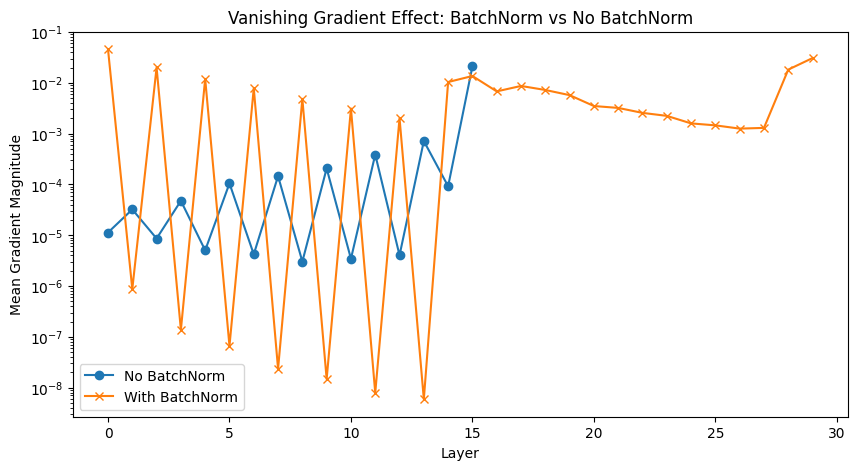

In [9]:
# Plot gradient comparison
plt.figure(figsize=(10, 5))
plt.plot(gradients_no_bn, label="No BatchNorm", marker='o')
plt.plot(gradients_bn, label="With BatchNorm", marker='x')
plt.yscale('log')
plt.xlabel("Layer")
plt.ylabel("Mean Gradient Magnitude")
plt.title("Vanishing Gradient Effect: BatchNorm vs No BatchNorm")
plt.legend()
plt.show()